TO DO LIST:
- check if the reverse-scaling is needed
- check the warning
- how to see it in the map?
- how to save the aggregated image?

In [37]:
import rasterio
from rasterio.plot import show
from matplotlib import pyplot as plt

In [38]:
from pystac_client import Client
from odc.stac import load
import odc.geo

In [39]:
# use publically available stac link such as
client = Client.open("https://earth-search.aws.element84.com/v1") 

# ID of the collection
collection = "sentinel-2-l2a"

# Geometry of AOI
geometry = {
    "coordinates": [
        [
            [12.57952494681641,42.173988781433145],
            [12.58948130667969,42.12880960265559],
            [12.639263105996097,42.135302116134895],
            [12.610423994667972,42.18047666209273],
            [12.57952494681641,42.173988781433145]
            
        ]
    ],
    "type": "Polygon",
}

here there are different ways to select the images 

In [40]:
# Specific Date
date_YYMMDD = "2024-01-21"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_YYMMDD
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())


{'type': 'FeatureCollection', 'features': []}


In [41]:
# Date range
date_range = "2023-01-10/2023-01-20"
# run pystac client search to see available dataset
search = client.search(
    collections=[collection], intersects=geometry, datetime=date_range
)
# spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2A_33TTG_20230120_0_L2A', 'properties': {'created': '2023-01-20T17:09:29.744Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 100, 'proj:epsg': 32633, 'mgrs:utm_zone': 33, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'TG', 'grid:code': 'MGRS-33TTG', 'view:sun_azimuth': 160.809858121116, 'view:sun_elevation': 25.6528949747656, 's2:degraded_msi_data_percentage': 0.0017, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0, 's2:cloud_shadow_percentage': 0, 's2:vegetation_percentage': 0, 's2:not_vegetated_percentage': 0, 's2:water_percentage': 0, 's2:unclassified_percentage': 0, 's2:medium_proba_clouds_percentage': 79.913032, 's2:high_proba_clouds_percentage': 20.086966, 's2:thin_cirrus_percentage': 0, 's2:snow_ice_percentage': 0, 's2:product_type': 'S2MSI2A', 's2:processing_baselin

In [42]:
# additional filters as per metadata 
filters = {
    #"eo:cloud_cover":{"lt":0.2},
    "s2:vegetation_percentage": {"gt": 25}
}
date_YYMM = "2023-01"
# run pystac client search to see available dataset 
search = client.search(collections=[collection], intersects=geometry , query=filters ,datetime=date_YYMM) #bbox=tas_bbox
#spit out data as GeoJSON dictionary
print(search.item_collection_as_dict())
# loop through each item
for item in search.items_as_dicts():
    print(item)

{'type': 'FeatureCollection', 'features': [{'type': 'Feature', 'stac_version': '1.0.0', 'id': 'S2A_33TTG_20230130_0_L2A', 'properties': {'created': '2023-01-30T18:20:37.718Z', 'platform': 'sentinel-2a', 'constellation': 'sentinel-2', 'instruments': ['msi'], 'eo:cloud_cover': 0.541982, 'proj:epsg': 32633, 'mgrs:utm_zone': 33, 'mgrs:latitude_band': 'T', 'mgrs:grid_square': 'TG', 'grid:code': 'MGRS-33TTG', 'view:sun_azimuth': 159.498773758244, 'view:sun_elevation': 27.8808763450362, 's2:degraded_msi_data_percentage': 0.0014, 's2:nodata_pixel_percentage': 0, 's2:saturated_defective_pixel_percentage': 0, 's2:dark_features_percentage': 0.140272, 's2:cloud_shadow_percentage': 0.011908, 's2:vegetation_percentage': 33.353281, 's2:not_vegetated_percentage': 13.535738, 's2:water_percentage': 52.341694, 's2:unclassified_percentage': 0.008451, 's2:medium_proba_clouds_percentage': 0.024097, 's2:high_proba_clouds_percentage': 0.006639, 's2:thin_cirrus_percentage': 0.511246, 's2:snow_ice_percentage': 

This is where odc-stac will be helpful, it converts data into xarray Dataset


In [50]:
#load the data in xarray format
data = load(search.items() ,geopolygon=geometry,groupby="solar_day", chunks={})

In [51]:
# The scaling factor  is used to convert these digital number values (integers) to actual physical reflectance values. 
def ReverseScalingFactor(band,prop):
  return search.item_collection_as_dict()['features'][0]['assets'][band]['raster:bands'][0][prop]


data["nir"] = data["nir"] * ReverseScalingFactor('nir', 'scale')
data["red"] = data["red"] * ReverseScalingFactor('red', 'scale')


# i proceed with creating an aggregated median image 
median_img = data.median(dim='time')
print(median_img)

<xarray.Dataset> Size: 68MB
Dimensions:       (y: 569, x: 482)
Coordinates:
  * y             (y) float64 5kB 4.673e+06 4.673e+06 ... 4.667e+06 4.667e+06
  * x             (x) float64 4kB 3.001e+05 3.001e+05 ... 3.049e+05 3.049e+05
    spatial_ref   int32 4B 32633
Data variables: (12/32)
    aot           (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    blue          (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    coastal       (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    green         (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    nir           (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    nir08         (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    ...            ...
    rededge3-jp2  (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.ndarray>
    scl-jp2       (y, x) float64 2MB dask.array<chunksize=(569, 482), meta=np.n

In [74]:
median_dataarray = median_img.to_array('band')
median_dataarray.shape

(32, 569, 482)

In [ ]:
img = rasterio.open('median_img.tiff')
show(img)

Let's compute the NDVI

In [52]:
RED = median_img["red"]
NIR = median_img["nir"]

numerator = NIR - RED
denominator = NIR + RED
NDVI = numerator / denominator
print(NDVI)


<xarray.DataArray (y: 569, x: 482)> Size: 2MB
dask.array<truediv, shape=(569, 482), dtype=float64, chunksize=(569, 482), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5kB 4.673e+06 4.673e+06 ... 4.667e+06 4.667e+06
  * x            (x) float64 4kB 3.001e+05 3.001e+05 ... 3.049e+05 3.049e+05
    spatial_ref  int32 4B 32633


In [67]:
print(NDVI.shape)

(569, 482)


In [53]:
odc.geo.xr.write_cog(NDVI,fname='ndvi.tiff',  overwrite=True)

PosixPath('ndvi.tiff')

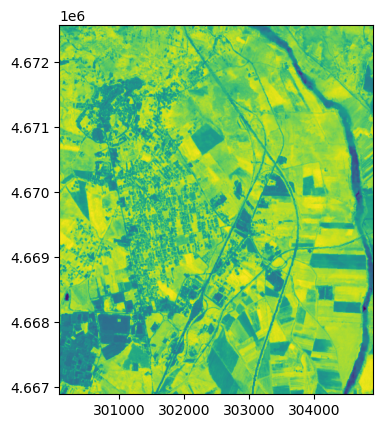

<Axes: >

In [54]:
img = rasterio.open("./ndvi.tiff")
show(img)

In [58]:
# Apply the mask: NDVI > 0.4
mask_NDVI = NDVI > 0.4

# Mask the original data using the mask
masked_data = median_img.where(mask_NDVI)

you can use GDAL or rasterio to reproject the tiff to EPSG:4326 ( In which we have our original geometry)

In [55]:
# Add Imports
from osgeo import gdal
import rasterio as rio
from rasterio import mask as msk

# Reproject file to EPSG:4326
input_file = f"ndvi.tiff"
# Path to save the reprojected GeoTIFF file
output_file = f"ndvi_reprojected.tiff"
# Define the target CRS (EPSG:4326)
dst_crs = 'EPSG:4326'
input_raster = gdal.Open(input_file)
warp = gdal.Warp(output_file, input_raster, dstSRS=dst_crs)


# Open reprojected raster
raster = rio.open(output_file)
# Use masking from rasterio to clip according to geometry
with raster as src:
    out_image, out_transform = msk.mask(src, [geometry], crop=True)
    out_meta = src.meta.copy()
    out_meta.update(
        {
            "driver": "GTiff",
            "height": out_image.shape[1],
            "width": out_image.shape[2],
            "transform": out_transform,
            "nodata": 0,
        }
    )
# set new file path
farmpath = f"final_ndvi.tiff"
# Export newly created raster
with rio.open(farmpath, "w", **out_meta) as dest:
    dest.write(out_image)
    dest.close()

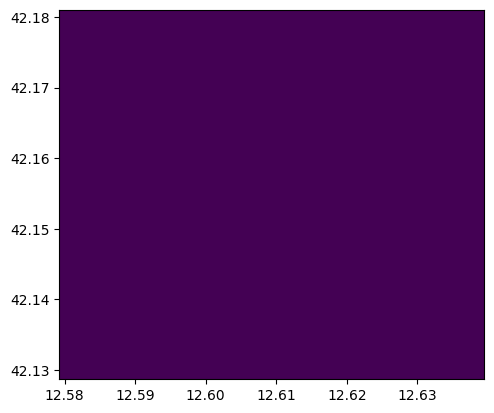

<Axes: >

In [56]:
img = rasterio.open("./ndvi_reprojected.tiff")
show(img)